# 4. HPO

In [ ]:
# Load usefull libraries and helper functions
%run libs_and_utils

In [1]:
# Load data
df_train = pd.read_csv(r'input/creditcard_train.csv')
df_train.sort_values(by=['Time'], inplace=True)
df_test = pd.read_csv(r'input/creditcard_test.csv')
df_test.sort_values(by=['Time'], inplace=True)

X_train = df_train.drop(columns='Class')
y_train = df_train.Class
X_test = df_test.drop(columns='Class')
y_test = df_test.Class
print('data_loaded')

libraries loaded


## Hyperparameter Optimisation

LGBMClassifier model training...


C:\Users\evgen\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\evgen\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Optimized parameters:     ['num_leaves', 'reg_lambda', 'max_depth', 'min_data_in_leaf', 'max_bin', 'learning_rate']
Previous best parameters: None
Current  best parameters: [130, 31.902619695224484, 52, 106, 1135, 0.7544693634434985]
Best score: 0.8689303109407065


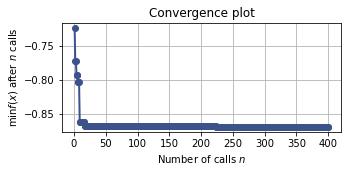

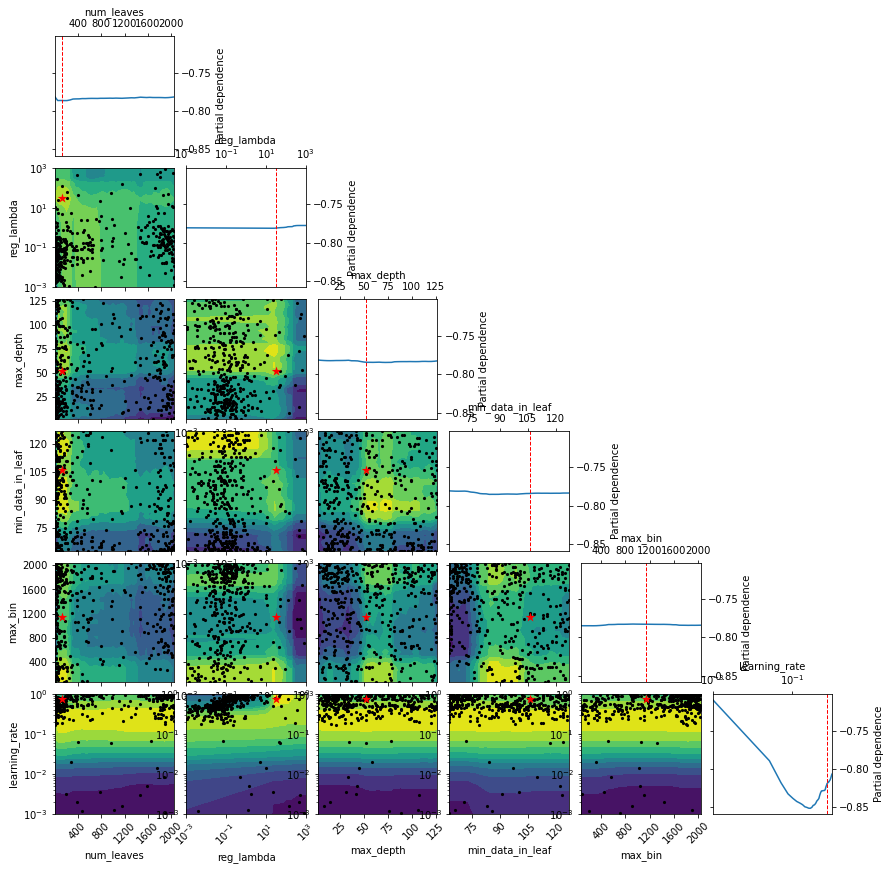

Wall time: 1h 27min 48s


In [57]:
%%time

model_params = {'class_weight': 'balanced', 'num_threads': -1, 'learning_rate': 0.1}

model = LGBMClassifier(**model_params)

dynamic_params_space  = [Integer(7, 2047, name='num_leaves'),
                         Real(1e-3, 1e3, prior='log-uniform', name='reg_lambda'), #L2 reg
                         Integer(2, 127, name='max_depth'),
                         Integer(63, 127, name='min_data_in_leaf'),
                         Integer(63, 2047, name='max_bin'),
                         Real(1e-3, 1, prior='log-uniform', name='learning_rate'),
                         #Real(1e-3, 1, prior='log-uniform', name='alpha_over') 
                        ]

HPO_params = {'n_calls': 400, 'n_random_starts': 20, 'random_state': 42}

find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = auprc_score, plot = True, nfold=5, **HPO_params)

In [58]:
model = load_best_parameters(model)
print(model)

LGBMClassifier optimized parameters: {'num_leaves': 130, 'reg_lambda': 31.902619695224484, 'max_depth': 52, 'min_data_in_leaf': 106, 'max_bin': 1135, 'learning_rate': 0.7544693634434985}
LGBMClassifier(class_weight='balanced', learning_rate=0.7544693634434985,
               max_bin=1135, max_depth=52, min_data_in_leaf=106, num_leaves=130,
               num_threads=-1, reg_lambda=31.902619695224484)


Training LGBMClassifier ...
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1


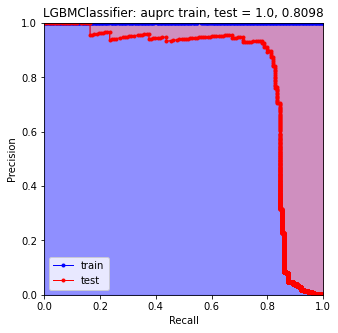

In [59]:
plot_auprc(model, X_train, y_train, X_test, y_test)

## Hyperparameter Optimisation with Under/Oversampling

### Undersampling
- Undersampling is required for the mainly for speeding up the calculations.
- Random inavitably undersampling causes loss of data.
- Clever undersampling techniques exist in addition to random undersampling https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html. What they do is - they implement some clever algorithm to remove some samples, which might help the model, however I prefer to give the task of finding best separation between the classes to the model itself. It should probably be helpfull with less complex algorithms like LogReg.
- Undersampling can work here as ensembling technique because 

LGBMClassifier model training...
['num_leaves', 'reg_lambda', 'max_depth', 'min_data_in_leaf', 'max_bin', 'learning_rate', 'alpha_over', 'k_neighbors']
Optimized parameters:     ['num_leaves', 'reg_lambda', 'max_depth', 'min_data_in_leaf', 'max_bin', 'learning_rate', 'alpha_over', 'k_neighbors']
Previous best parameters: [84, 17.85065173956312, 63, 127, 387, 0.40149867291349095, 0.03707843493022179, 8]
Current  best parameters: [1465, 44.23098866840935, 12, 167, 318, 0.4014212449851396, 0.13254115831177898, 10]
Best score: 0.8724797213688349


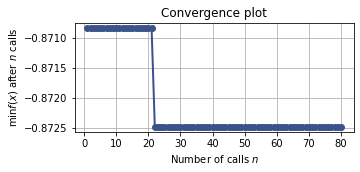

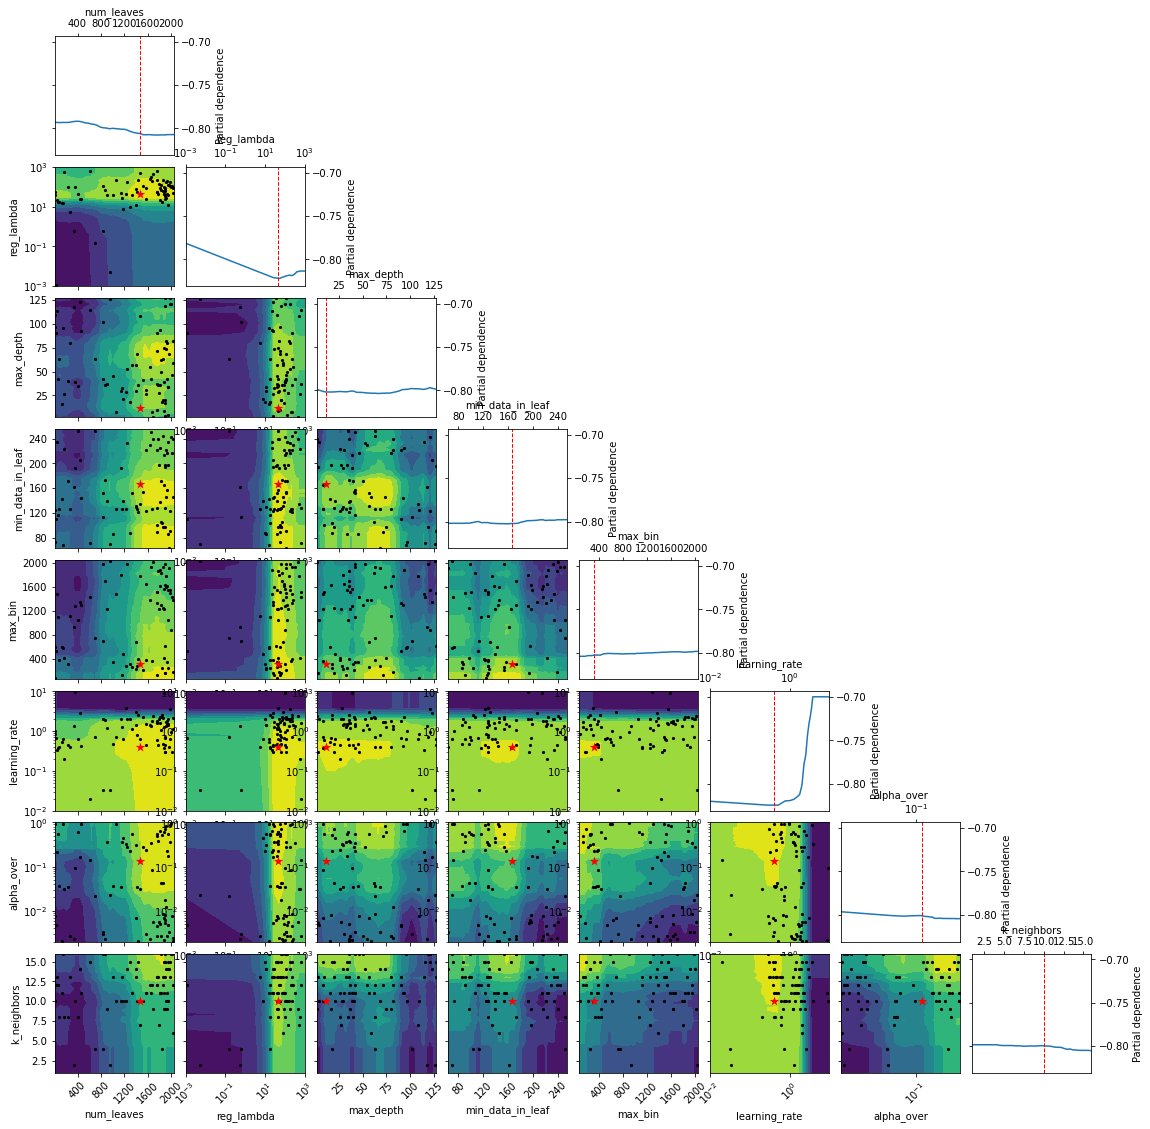

Wall time: 31min 14s


In [62]:
%%time

model_params = {
    'class_weight':  'balanced',
    'num_threads':   -1,
    'learning_rate': 1,
    'random_state':  seed
               }

model = LGBMClassifier(**model_params)

dynamic_params_space  = [
    Integer(7, 2047, name='num_leaves'),
    Real(1e-3, 1e3, prior='log-uniform', name='reg_lambda'), #L2 reg
    Integer(2, 127, name='max_depth'),
    Integer(63, 255, name='min_data_in_leaf'),
    Integer(63, 2047, name='max_bin'),
    Real(1e-2, 10, prior='log-uniform', name='learning_rate'),
                         
    # resampling parameters
    Real(2e-3, 1, prior='log-uniform', name='alpha_over'),
    Integer(1, 16, name='k_neighbors'),
                        ]

HPO_params = {
    'n_calls': 80,
    'n_random_starts': 10,
    'random_state': seed
             }

find_best_hyperparameters_sampling(model,  X_train, y_train, dynamic_params_space, scoring = auprc_score, plot = True, nfold=5, **HPO_params)

In [64]:
model, alpha_over, k_neighbors = load_best_parameters_sampling(model)
#print(model)
print(alpha_over, k_neighbors)

LGBMClassifier optimized parameters: {'num_leaves': 1465, 'reg_lambda': 44.23098866840935, 'max_depth': 12, 'min_data_in_leaf': 167, 'max_bin': 318, 'learning_rate': 0.4014212449851396}
0.13254115831177898 10


In [65]:
print(X_train.shape, y_train.shape, sum(y_train==1))

over = SMOTE(random_state=42, sampling_strategy=alpha_over, k_neighbors=k_neighbors)
X_train_res, y_train_res = over.fit_resample(X_train, y_train)

print(X_train_res.shape, y_train_res.shape, sum(y_train_res==1))

(199364, 30) (199364,) 364
(225375, 30) (225375,) 26375


Training LGBMClassifier ...


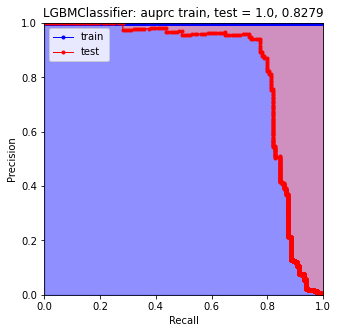

In [67]:
plot_auprc(model, X_train_res, y_train_res, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=167
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1


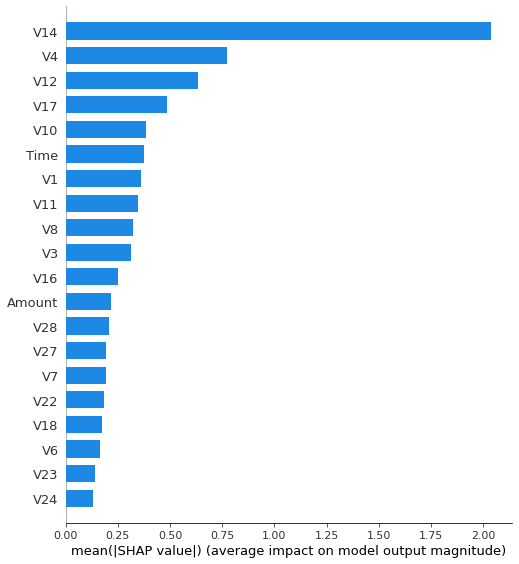

In [68]:
plot_shap_feature_importance(model, X_train_res, y_train_res)